# Two-layer custom CNN with MOSAIKS+KMeans

## Load utils

In [1]:
import os
import sys
import time
import inspect
import math
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.feature_extraction.image import extract_patches_2d
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import timm

from sklearn.cluster import KMeans


CURR_DIR = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
PARENT_DIR = os.path.dirname(CURR_DIR)
sys.path.insert(0, "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/remote_sensing")

from dataset.pytorch_dataset import GeoLifeCLEF2022Dataset
from torch.utils.data import random_split, DataLoader
from mosaiks_utils import visualize_3d_patches, visTensor, normalize_patches, DBN

/home/mila/s/sara.ebrahim-elkafrawy/.conda/envs/ffcv2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load GeoLifeCLEF dataset

In [2]:
data_dir = "/network/scratch/s/sara.ebrahim-elkafrawy/small_geo_data"  # "/network/scratch/s/sara.ebrahim-elkafrawy/" 
split = "train"
use_ffcv_loader = False
num_species= 17037
bands = ["rgb"] 
batch_size = 1
num_workers = 0

In [25]:
geo_train_dataset = GeoLifeCLEF2022Dataset(
                root=data_dir,
                subset=split,
                use_ffcv_loader=use_ffcv_loader,
                region="both",
                patch_data=bands,
                use_rasters=False,
                patch_extractor=None,
                transform=None,
                target_transform=None,
                opts=None,
            )

geo_train_loader = DataLoader(
                    geo_train_dataset,
                    batch_size=batch_size,
                    num_workers=num_workers,
                    shuffle=True,
                )
# trf = torch.nn.Sequential(
#     transforms.Resize(size=(224, 224), interpolation=transforms.InterpolationMode.NEAREST),
#     transforms.Normalize((106.9413, 114.8733, 104.5285), (51.0005, 44.8595, 43.2014)),
# )

## Define the model: two-layer CNN

In [3]:
# hyperparameters for the model
kernel_size = 7
mode = 'whiten' # options ['whiten', 'no_whiten']
whiten = True
save_path = f"/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/ckpts/two_layer_mosaiks_kmeans_{kernel_size}_{mode}.pt"
max_iter = 6
random_state = np.random.RandomState(0)

In [27]:
model = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=64, kernel_size=kernel_size, padding='same', bias=True),
      nn.LeakyReLU(),
      nn.MaxPool2d(2, stride=2),

      nn.Conv2d(in_channels=64, out_channels=64, kernel_size=7, padding='same', bias=True),
      nn.LeakyReLU(),
      nn.MaxPool2d(2, stride=2),
    
      nn.AdaptiveAvgPool2d(9),
    
      nn.Flatten(),
      nn.Dropout(0.5),
      nn.Linear(5184, 512), #50176
      nn.ReLU(),
      nn.Linear(512, num_species)
      ) 
model(torch.rand((1, 3, 224, 224))).shape

torch.Size([1, 17037])

## Multi-layer Mosaiks

In [6]:
# model = nn.Sequential(
#       nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, padding='same', bias=True),
#       nn.LeakyReLU(),
#       nn.MaxPool2d(2, stride=2),

#       nn.Conv2d(in_channels=64, out_channels=64, kernel_size=7, padding='same', bias=True),
#       nn.LeakyReLU(),
#       nn.MaxPool2d(2, stride=2),

#       nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same', bias=True),
#       nn.LeakyReLU(),
#       nn.MaxPool2d(2, stride=2),

#       nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same', bias=True),
#       nn.LeakyReLU(),
#       nn.MaxPool2d(2, stride=2),
    
#       nn.AdaptiveAvgPool2d(9),
    
#       nn.Flatten(),
#       nn.Dropout(0.5),
#       nn.Linear(20736, 512), #50176
#       nn.ReLU(),
#       nn.Linear(512, num_species)
#       ) 
# model(torch.rand((1, 3, 224, 224))).shape

## slicing up the network

In [7]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (1): LeakyReLU(negative_slope=0.01)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (4): LeakyReLU(negative_slope=0.01)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): AdaptiveAvgPool2d(output_size=9)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=5184, out_features=512, bias=True)
  (10): ReLU()
  (11): Linear(in_features=512, out_features=17037, bias=True)
)

## Manually set the indices of all convolution layers and the afterwards activation layers

In [8]:
# for 2-conv layers
conv_lyrs = [0, 3]
act_lyrs = [1, 4]

# for 4-conv layers
# conv_lyrs = [0, 2, 4, 6]
# act_lyrs = [1, 4, 7, 10]

In [9]:
for name, param in model.named_parameters():
    print(name, '---------------\t', param.shape)

0.weight ---------------	 torch.Size([64, 3, 7, 7])
0.bias ---------------	 torch.Size([64])
3.weight ---------------	 torch.Size([64, 64, 7, 7])
3.bias ---------------	 torch.Size([64])
9.weight ---------------	 torch.Size([512, 5184])
9.bias ---------------	 torch.Size([512])
11.weight ---------------	 torch.Size([17037, 512])
11.bias ---------------	 torch.Size([17037])


## Hooks for activation layers

In [10]:
features_dim = {}
def get_features(name):
    def hook(model, input, output):
        features_dim[name] = output.detach()
    return hook

In [11]:
# for 2-conv layers
model[1].register_forward_hook(get_features('relu_layer_1'))
model[4].register_forward_hook(get_features('relu_layer_4'))


# for 4-conv layers (without nn.AdaptivePool layer)
# model[1].register_forward_hook(get_features('relu_layer_1'))
# model[4].register_forward_hook(get_features('relu_layer_4'))
# model[7].register_forward_hook(get_features('relu_layer_7'))
# model[10].register_forward_hook(get_features('relu_layer_10'))

In [12]:
def get_featuremap_patches(train_dataloader, layer_idx, patch_size, max_patches, random_state):
    '''expects image shape of (width, height, n_channels)
    
    Parameters
    ----------
    train_dataloader: Dataset
                   dataloader for the training dataset to extract from
    
    layer_idx: int
               The index of the current feature map. 
               conv_lyrs[layer_idx] should return the real index of the current weights/parameter 
               
    patch_size: (int, int)
                Receptive field size or width and height of the extracted patch.
                
    max_patches: int
                 The number of extracted patches.
    
    random_state: int
                  Random state for reproducibility 
    Return
    ------
    patches: ndarrah
             final patches of size (max_patches, patch_size, n_channels)
    '''
    all_patches = []
    
    
    for batch in train_dataloader:
        patches, target, meta = batch
        
        if layer_idx == 0:
            curr_feat_map = patches['rgb'].numpy()
        else:
            output = model(patches['rgb'])
            curr_feat_map = features_dim[f'relu_layer_{act_lyrs[layer_idx-1]}'].numpy()

        curr_feat_map = curr_feat_map.squeeze(0)
        curr_feat_map = curr_feat_map.transpose((1,2,0))

        # curr_feat_map: expected shape: (width, height, n_channels)
        # output shape: (max_patches, patch_size, n_channels)
        random_patches =  extract_patches_2d(curr_feat_map, 
                                 patch_size, 
                                 max_patches=max_patches,
                                 random_state=random_state)

        random_patches = np.reshape(random_patches, (len(random_patches), -1))

        all_patches.append(random_patches)
    
    return np.concatenate(all_patches, axis=0)

# Debug the steps

## Step #1: Extract random patches

In [13]:
# first layer
curr_param_sz = model[0].weight.data.shape
num_clusters = curr_param_sz[0]  # number of output filters/kernels in a layer
num_ch = curr_param_sz[1]    # number of channels
patch_size = (curr_param_sz[2], curr_param_sz[3])  # filter/kernel's width and height
max_patches = int(num_clusters/4)  # number of random patches to extract from each image/feature map

In [15]:
dbn = DBN(64, 32, affine=False, momentum=1.)
x = torch.randn(2, 64, 7, 7)
print(dbn)
y = dbn(x)
print('y size:', y.size())

DBN(64, num_groups=32, eps=1e-05, momentum=1.0, affine=False, mode=0)
y size: torch.Size([2, 64, 7, 7])


In [13]:
# # patches from the original image to initialize first conv layer
# conv1_patches = get_featuremap_patches(geo_train_loader, 
#                                        layer_idx=0, 
#                                        patch_size=patch_size, 
#                                        max_patches=max_patches, 
#                                        random_state=random_state)
# visualize_3d_patches(conv1_patches, kernel_size=kernel_size, nrows=10)

In [46]:
tmp = torch.from_numpy(conv1_patches.reshape(-1, kernel_size, kernel_size, 3).transpose(0, 3, 1, 2))
tmp.shape

torch.Size([32064, 3, 25, 25])

In [47]:
dbn = DBN(3, 3, affine=False, momentum=1.)  # num_features = num_ch
x = torch.randn(2, 64, 7, 7)
print(dbn)
y = dbn(tmp)
y.shape

DBN(3, num_groups=3, eps=1e-05, momentum=1.0, affine=False, mode=0)


torch.Size([32064, 3, 25, 25])

In [48]:
tmp.shape

torch.Size([32064, 3, 25, 25])

In [50]:
y_np = y.numpy().transpose(0, 2, 3, 1).reshape(-1, kernel_size * kernel_size * 3)
print(tmp_np.shape)

(32064, 1875)


In [14]:
# visualize_3d_patches(y_np, kernel_size=kernel_size, nrows=10)

## Step #2: Normalize and Whiten the patches

In [15]:
# whiten_imgs = normalize_patches(conv1_patches, whiten=False)
# visualize_3d_patches(whiten_imgs, kernel_size=kernel_size, nrows=10)

## Step #3: Apply KMeans to the whitened patches

In [16]:
# ([64, 3, 7, 7])
kmeans = KMeans(n_clusters=64, 
                 random_state=random_state,
                 max_iter=6,
                 verbose=False)
kmeans_geo = kmeans.fit(whiten_imgs)

In [17]:
kmeans_geo.cluster_centers_.shape

(64, 147)

## Visualize the filters

In [16]:
# filters = torch.from_numpy(kmeans_geo.cluster_centers_.reshape(64, kernel_size, kernel_size, 3).transpose(0, 3, 1, 2))

# visTensor(filters, ch=0, allkernels=False)

# plt.axis('off')
# plt.ioff()
# plt.rcParams['savefig.facecolor']='white'
# plt.savefig(f'conv1_{str(kernel_size)}_{mode}_color.png')
# plt.show()

In [17]:
# visualize_3d_patches(kmeans_geo.cluster_centers_, 
#                      kernel_size=kernel_size, 
#                      nrows=8)

## Sanity check: visualize the images

In [57]:
def show_image(img, dim=256, ch=3):
    img = img.reshape((dim,dim,ch))
    img_min, img_max = img.min(), img.max()
    plt.imshow((img - img_min) / (img_max - img_min))
    plt.show()

In [14]:
# dbn = DBN(3, 3, affine=False, momentum=1.)  # num_features = num_ch


# train_loader = DataLoader(
#                 geo_train_dataset,
#                 batch_size=1,
#                 num_workers=num_workers,
#                 shuffle=True,
#             )

# for batch in train_loader:
#     patches, target, meta = batch

#     curr_feat_map = dbn(patches['rgb']).numpy()
# #     print(curr_feat_map[0])
# #     curr_feat_map = patches['rgb'].numpy()

    
#     curr_feat_map = curr_feat_map.squeeze(0)
#     curr_feat_map = curr_feat_map.transpose((1,2,0))
#     print(curr_feat_map.shape)
#     show_image(curr_feat_map)

# debug the whiten model weights

In [28]:
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

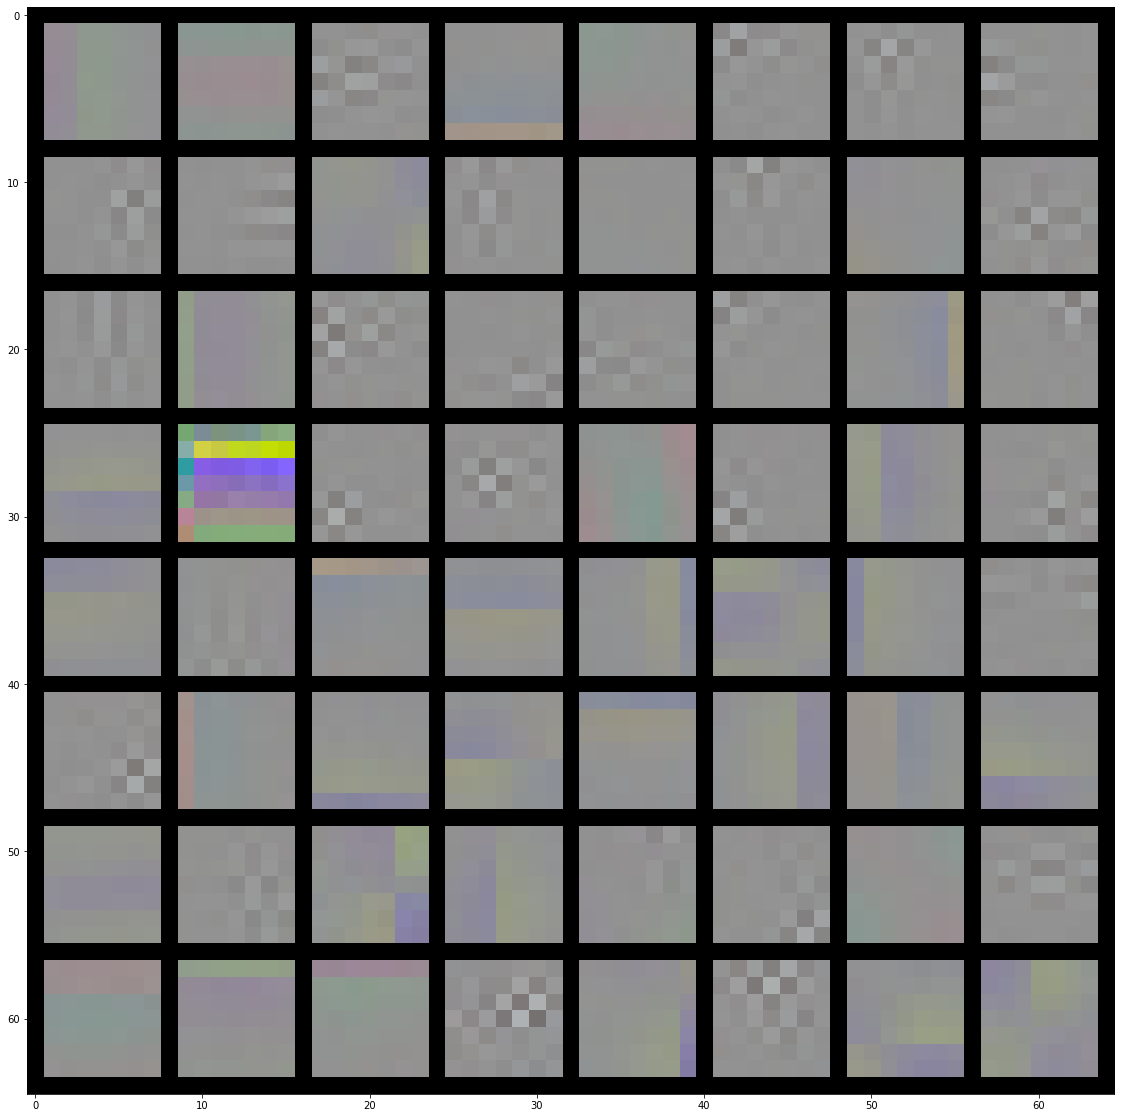

In [29]:
visTensor(model[0].weight.data, ch=0, allkernels=False)

In [6]:
model_whiten = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=64, kernel_size=kernel_size, padding='same', bias=True),
      nn.LeakyReLU(),
      nn.MaxPool2d(2, stride=2),

      nn.Conv2d(in_channels=64, out_channels=64, kernel_size=7, padding='same', bias=True),
      nn.LeakyReLU(),
      nn.MaxPool2d(2, stride=2),
    
      nn.AdaptiveAvgPool2d(9),
    
      nn.Flatten(),
      nn.Dropout(0.5),
      nn.Linear(5184, 512), #50176
      nn.ReLU(),
      nn.Linear(512, num_species)
      ) 
model_whiten_path = "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/ckpts/two_layer_mosaiks_kmeans_7_whiten.pt"
model_whiten.load_state_dict(torch.load(model_whiten_path))

<All keys matched successfully>

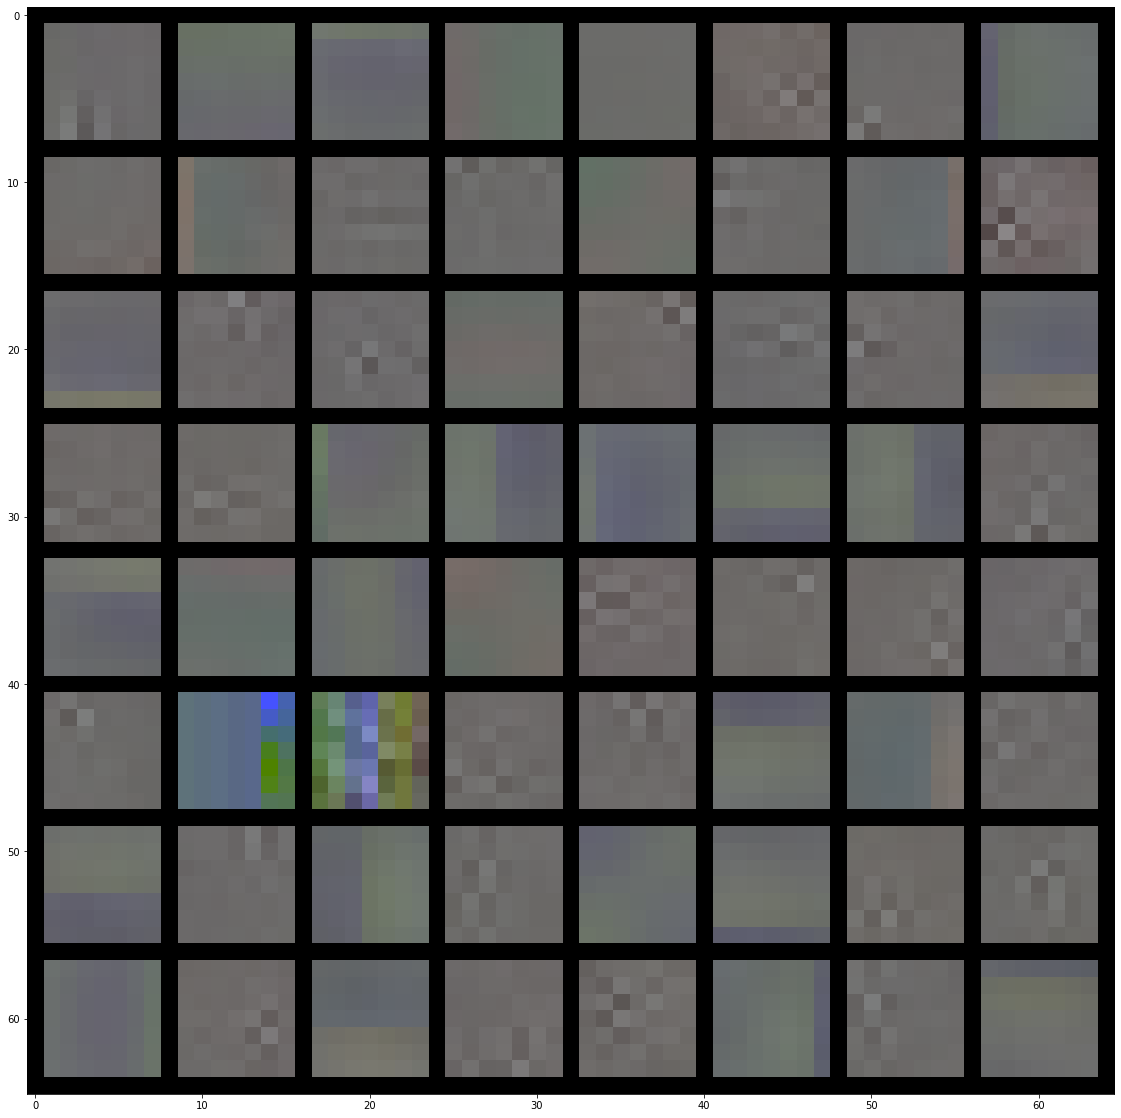

In [7]:
visTensor(model_whiten[0].weight.data, ch=0, allkernels=False)


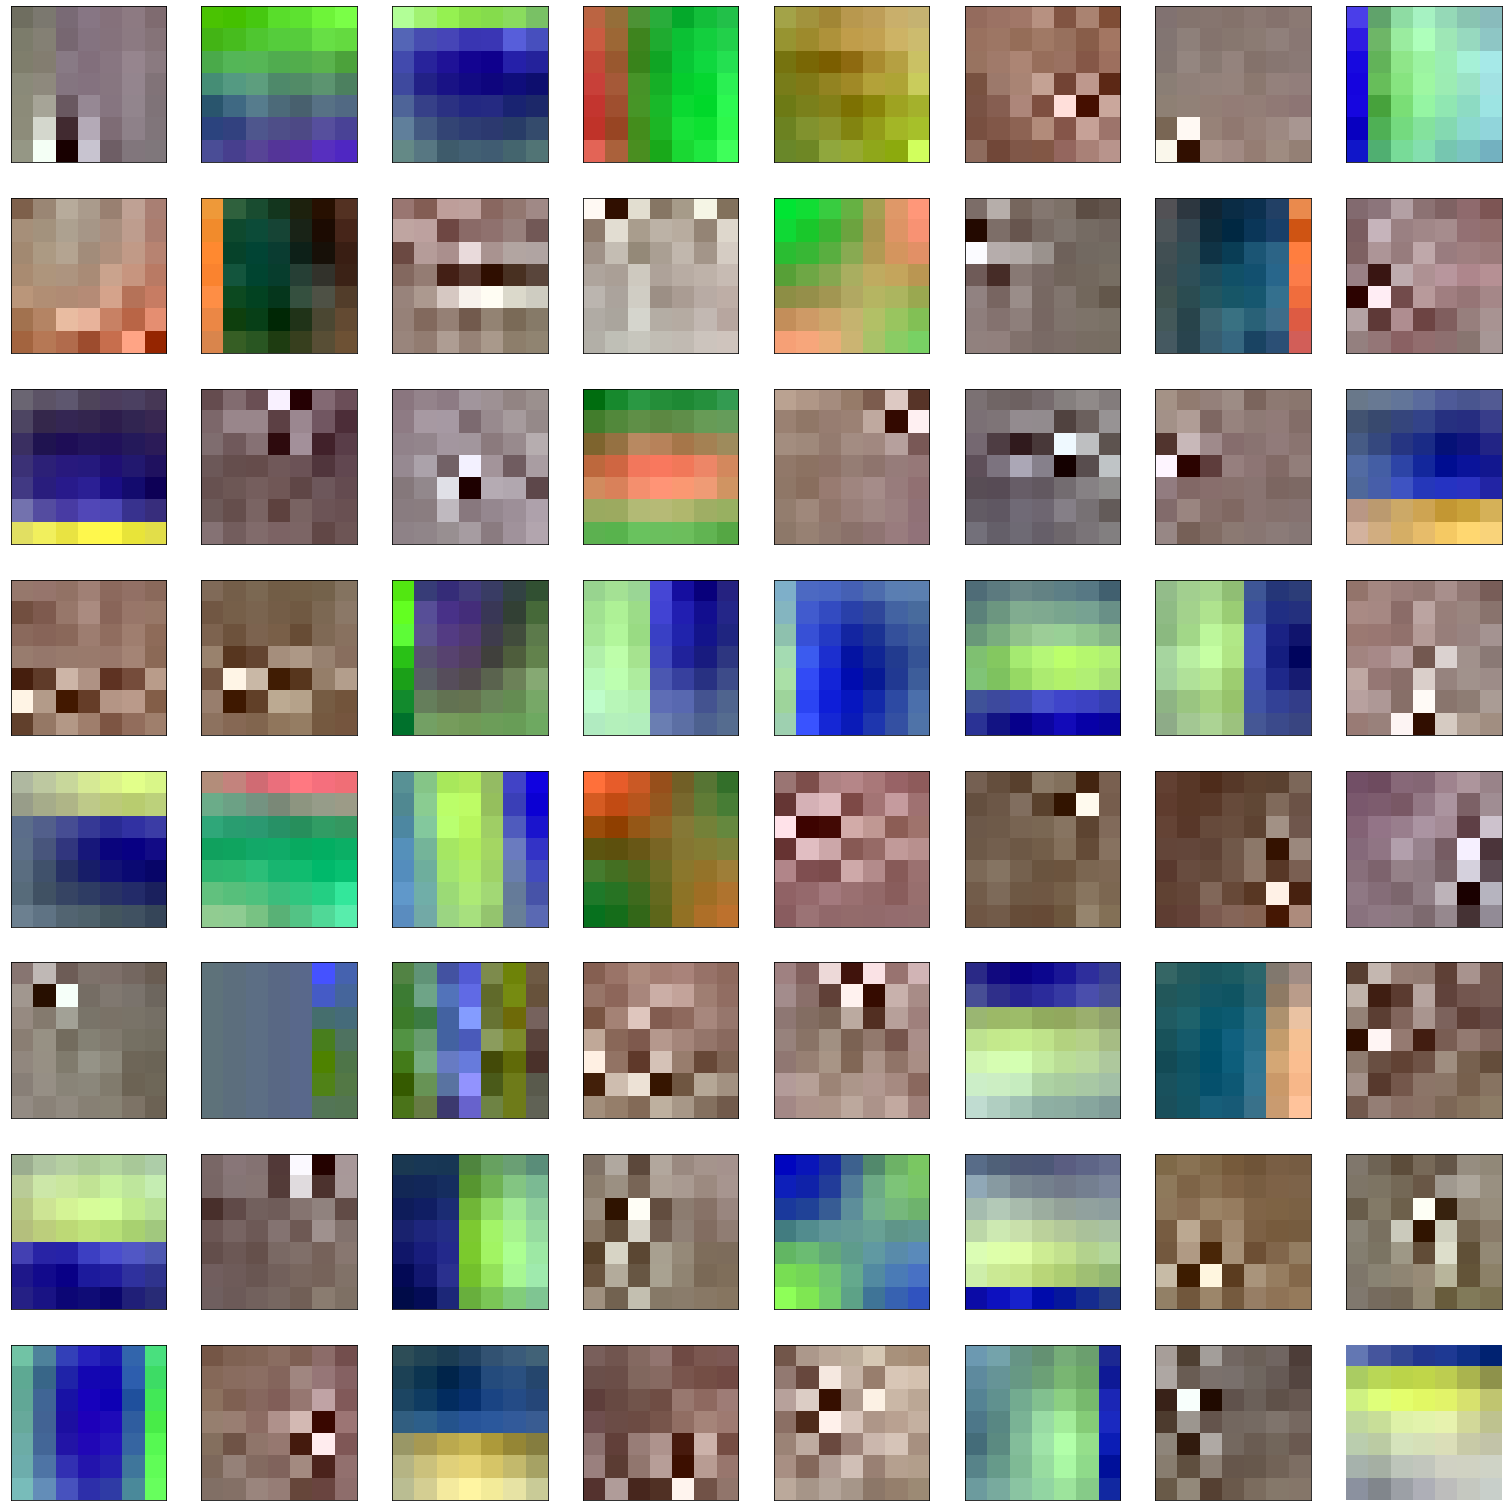

In [9]:
filter_shape = model_whiten[0].weight.data.shape
tmp_np = model_whiten[0].weight.data.numpy().transpose(0, 2, 3, 1).reshape(filter_shape[0], -1)
visualize_3d_patches(tmp_np, kernel_size=kernel_size, nrows=8)
plt.axis('off')
plt.ioff()
plt.rcParams['savefig.facecolor']='white'
# plt.savefig(f'conv1_{dataset}_{str(kernel_size)}_{mode}_color.png')
plt.show()

In [4]:
model_whiten = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=100, kernel_size=7, padding='same', bias=True),
      nn.LeakyReLU(),
      nn.MaxPool2d(2, stride=2),

      nn.Conv2d(in_channels=100, out_channels=64, kernel_size=7, padding='same', bias=True),
      nn.LeakyReLU(),
      nn.MaxPool2d(2, stride=2),
    
      nn.AdaptiveAvgPool2d(9),
    
      nn.Flatten(),
      nn.Dropout(0.5),
      nn.Linear(5184, 512), #50176
      nn.ReLU(),
      nn.Linear(512, num_species)
      ) 
model_whiten_path = "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/ckpts/two_layer_mosaiks_kmeans_7_whiten_allGeo_bs32_25eachimage_zcaBias_0.001.pt"
model_whiten.load_state_dict(torch.load(model_whiten_path))

<All keys matched successfully>

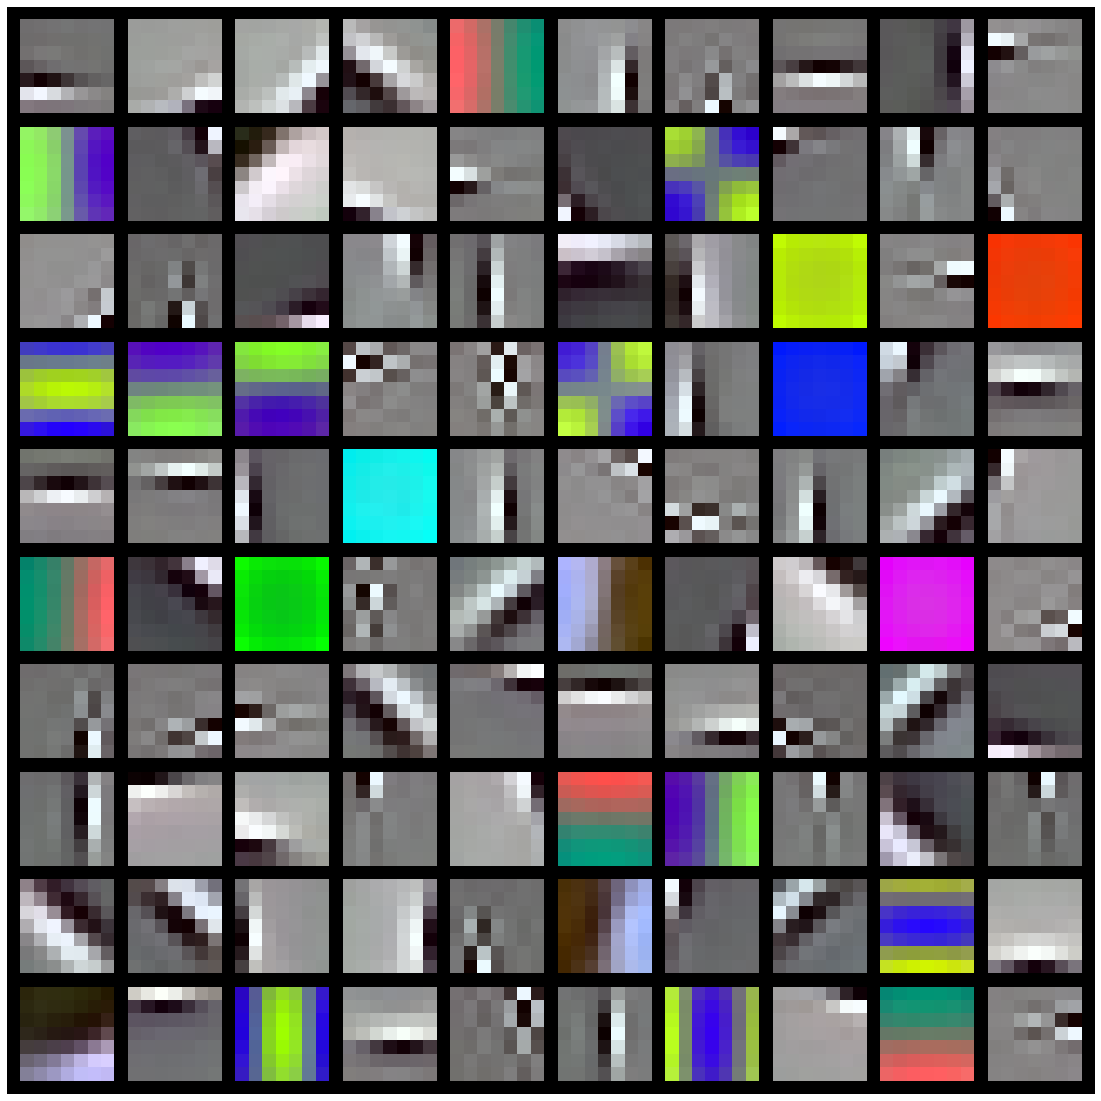

In [7]:
visTensor(model_whiten[0].weight.data, nrow=10, ch=0, allkernels=False)
plt.axis('off')
plt.ioff()
plt.rcParams['savefig.facecolor']='black'
plt.savefig(f'conv1_allGeo_bs32_25eachimage_zcaBias_0.001.png')
plt.show()

In [8]:
def check_weights(weights_data):
    print(f'min: {weights_data.min()}')
    print(f'max: {weights_data.max()}')
    print(f'mean: {weights_data.mean()}')
    print(f'std: {weights_data.std()}')
    print(f'num_complex numbers: {np.iscomplex(weights_data.numpy()).sum()}')

In [9]:
check_weights(model_whiten[0].weight.data)

min: -1.5757321119308472
max: 1.7271215915679932
mean: -1.244317928694727e-07
std: 0.2641446590423584
num_complex numbers: 0


In [36]:
check_weights(model_no_whiten[0].weight.data)

min: -0.19972139596939087
max: 0.17146986722946167
mean: 1.2671055316104685e-09
std: 0.05497889220714569
num_complex numbers: 0


In [37]:
check_weights(model_whiten[0].weight.data)

min: -1.1697169542312622
max: 1.4781373739242554
mean: 1.8246320010462114e-08
std: 0.22702325880527496
num_complex numbers: 0


In [42]:
filter_1 = model_whiten[0].weight.data[1]
filter_5 = model_whiten[0].weight.data[5]

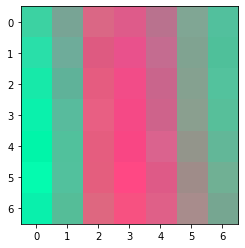

In [43]:
filter_1 = filter_1.numpy().transpose((1,2,0))
show_image(filter_1, dim=filter_1.shape[0])

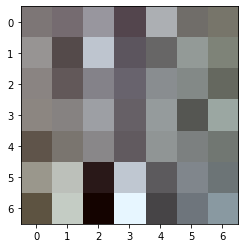

In [44]:
filter_5 = filter_5.numpy().transpose((1,2,0))
show_image(filter_5, dim=filter_5.shape[0])

In [47]:
filter_1.min(), filter_5.min()

(-10.3976965, -8.070095)

In [48]:
filter_1.max(), filter_5.max()

(7.622662, 8.373293)

In [49]:
filter_1.mean(), filter_5.mean()

(3.892548e-08, 5.117079e-07)

In [50]:
filter_1.std(), filter_5.std()

(3.8834505, 2.7545686)

In [53]:
model_whiten_Wnorm = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=64, kernel_size=kernel_size, padding='same', bias=True),
      nn.LeakyReLU(),
      nn.MaxPool2d(2, stride=2),

      nn.Conv2d(in_channels=64, out_channels=64, kernel_size=7, padding='same', bias=True),
      nn.LeakyReLU(),
      nn.MaxPool2d(2, stride=2),
    
      nn.AdaptiveAvgPool2d(9),
    
      nn.Flatten(),
      nn.Dropout(0.5),
      nn.Linear(5184, 512), #50176
      nn.ReLU(),
      nn.Linear(512, num_species)
      ) 
model_whiten_Wnorm_path = "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/ckpts/two_layer_mosaiks_kmeans_7_whiten+Wnorm_minibatch.pt"
model_whiten_Wnorm.load_state_dict(torch.load(model_whiten_Wnorm_path))

<All keys matched successfully>

In [54]:
check_weights(model_whiten_Wnorm[0].weight.data)

min: -5.985419273376465
max: 5.429774284362793
mean: 1.0947792006277268e-08
std: 1.0
num_complex numbers: 0
